# Task III (b)
Train a deep learning-based super-resolution algorithm of your choice to enhance low-resolution strong lensing images using a limited dataset of real HR/LR pairs collected from HSC and HST telescopes. You can adapt and fine-tune your super-resolution model from Task III.A. or use any other approach, such as few-shot learning strategies, transfer learning, domain adaptation, or data augmentation techniques, etc. Please implement your approach in PyTorch or Keras and discuss your strategy.


**Breakdown to approach**
Our approach involves fine-tuning an Enhanced Deep Super-Resolution (EDSR) model to improve the resolution of strong lensing images. The entire pipeline includes data handling, model architecture, training, and evaluation.

* Residual Blocks: 16 blocks with skip connections to enhance feature extraction.

* Upsampling Layer: Using PixelShuffle to upscale images better.

* Final Convolution: Converts the upsampled output into a single-channel grayscale image.

**Loss Function:** L1 loss, as it helps preserve structural details better than L2 loss.

**Optimizer:** Adam optimizer with a learning rate of 1e-4.

**Training Pipeline:**

* Loads LR and HR images as mini-batches.

* Feeds LR images into EDSR to generate SR images.

* Compares SR images with HR ground truth using L1 loss.

* Updates model weights using backpropagation.

## ESDR Model
The EDSR architecture is based on the SRResNet architecture and consists of multiple residual blocks. It uses constant scaling layers instead of batch normalization layers to produce consistent results (input and output have similar distributions, thus normalizing intermediate features may not be desirable). Instead of using a L2 loss (mean squared error), the authors employed an L1 loss (mean absolute error), which performs better empirically. Read more [here](https://keras.io/examples/vision/edsr/) and [here](https://medium.com/axinc-ai/edsr-a-machine-learning-model-for-super-resolution-image-processing-9deaf36b24ed)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os


# A custom PyTorch Dataset class loads these .npy files, applies transformations (converts them to tensors), and prepares them for training.

# Dataset class for handling HR and LR .npy files
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_files = sorted(os.listdir(lr_dir))
        self.hr_files = sorted(os.listdir(hr_dir))
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.lr_files)
    
    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.lr_files[idx])
        hr_path = os.path.join(self.hr_dir, self.hr_files[idx])
        
        lr_image = np.load(lr_path).astype(np.float32)
        hr_image = np.load(hr_path).astype(np.float32)
        
        # Convert (1, H, W) to (H, W) for transformation
        lr_image = lr_image.squeeze()
        hr_image = hr_image.squeeze()
        
        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)
        
        return lr_image, hr_image

# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Define EDSR Model
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return out + x  # Skip connection

#  EDSR removes batch normalization layers to reduce memory consumption and improve performance over traditional SR methods like SRCNN.

class EDSR(nn.Module):
    def __init__(self, num_blocks=16, channels=64, scale_factor=2):
        super(EDSR, self).__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=3, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(channels) for _ in range(num_blocks)])
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.upsample = nn.Sequential(
            nn.Conv2d(channels, channels * scale_factor**2, kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.Conv2d(channels, 1, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.res_blocks(x)
        x = self.conv2(x)
        x = self.upsample(x)
        return x

# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EDSR().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
def train(model, dataloader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for lr_imgs, hr_imgs in dataloader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            optimizer.zero_grad()
            sr_imgs = model(lr_imgs)
            loss = criterion(sr_imgs, hr_imgs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

# Load dataset
lr_dir = "/kaggle/input/dataset3b/Dataset/LR"
hr_dir = "/kaggle/input/dataset3b/Dataset/HR"
dataset = SuperResolutionDataset(lr_dir, hr_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Model Training
train(model, dataloader, criterion, optimizer, epochs=50)


Epoch [1/50], Loss: 0.0268
Epoch [2/50], Loss: 0.0185
Epoch [3/50], Loss: 0.0172
Epoch [4/50], Loss: 0.0164
Epoch [5/50], Loss: 0.0169
Epoch [6/50], Loss: 0.0165
Epoch [7/50], Loss: 0.0163
Epoch [8/50], Loss: 0.0158
Epoch [9/50], Loss: 0.0161
Epoch [10/50], Loss: 0.0160
Epoch [11/50], Loss: 0.0164
Epoch [12/50], Loss: 0.0160
Epoch [13/50], Loss: 0.0165
Epoch [14/50], Loss: 0.0169
Epoch [15/50], Loss: 0.0170
Epoch [16/50], Loss: 0.0164
Epoch [17/50], Loss: 0.0164
Epoch [18/50], Loss: 0.0158
Epoch [19/50], Loss: 0.0159
Epoch [20/50], Loss: 0.0160
Epoch [21/50], Loss: 0.0161
Epoch [22/50], Loss: 0.0158
Epoch [23/50], Loss: 0.0155
Epoch [24/50], Loss: 0.0156
Epoch [25/50], Loss: 0.0154
Epoch [26/50], Loss: 0.0156
Epoch [27/50], Loss: 0.0158
Epoch [28/50], Loss: 0.0154
Epoch [29/50], Loss: 0.0156
Epoch [30/50], Loss: 0.0157
Epoch [31/50], Loss: 0.0154
Epoch [32/50], Loss: 0.0161
Epoch [33/50], Loss: 0.0156
Epoch [34/50], Loss: 0.0154
Epoch [35/50], Loss: 0.0154
Epoch [36/50], Loss: 0.0154
E

In [2]:

import math
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


# Updated Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total_psnr = 0
    total_ssim = 0
    count = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in dataloader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)

            for i in range(sr_imgs.size(0)):
                sr_img = sr_imgs[i].squeeze().cpu().numpy()
                hr_img = hr_imgs[i].squeeze().cpu().numpy()

                # Ensure the image is large enough for SSIM window or reduce window size
                min_dim = min(sr_img.shape)
                window_size = min(7, min_dim if min_dim % 2 == 1 else min_dim - 1)

                psnr_value = psnr(hr_img, sr_img, data_range=1.0)
                ssim_value = ssim(hr_img, sr_img, data_range=1.0, win_size=window_size)

                total_psnr += psnr_value
                total_ssim += ssim_value
                count += 1

    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count
    print(f"Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}")
    return avg_psnr, avg_ssim

# Evaluate the model
evaluate(model, dataloader)


Average PSNR: 35.1517, Average SSIM: 0.8532


(35.15167287980025, 0.8532018298450911)

PSNR (Peak Signal-to-Noise Ratio): Measures how much the generated SR image resembles the HR image.

SSIM (Structural Similarity Index): Evaluates perceptual similarity.

**Scope of Improvement:**
* Data Augmentation: Rotation, flipping, and noise addition can improve generalization.
* Perceptual Loss: Combining L1 loss with VGG-based perceptual loss could yield sharper results.
* can try GAN-Based Approaches: ESRGAN or SRGAN can enhance textures.



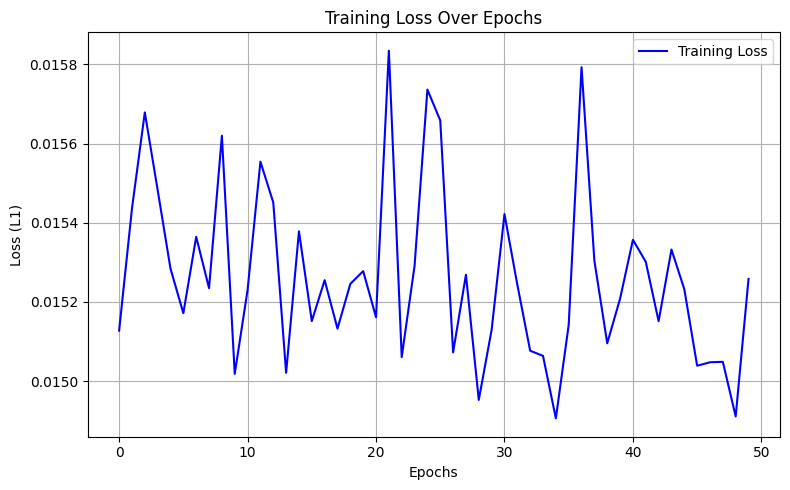

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss (L1)')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


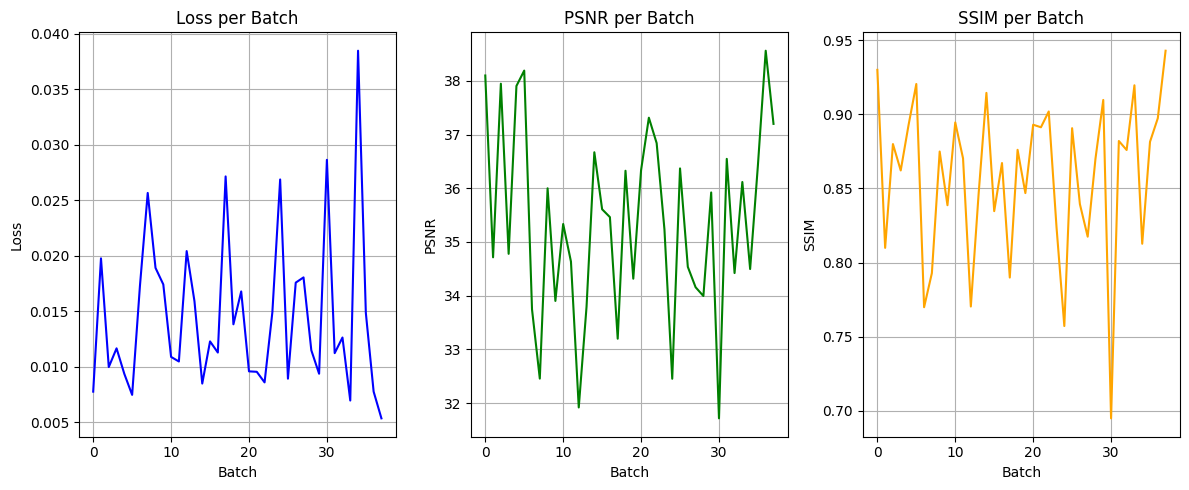

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(batch_losses, label="L1 Loss", color='blue')
plt.title("Loss per Batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(batch_psnr, label="PSNR", color='green')
plt.title("PSNR per Batch")
plt.xlabel("Batch")
plt.ylabel("PSNR")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(batch_ssim, label="SSIM", color='orange')
plt.title("SSIM per Batch")
plt.xlabel("Batch")
plt.ylabel("SSIM")
plt.grid(True)

plt.tight_layout()
plt.show()


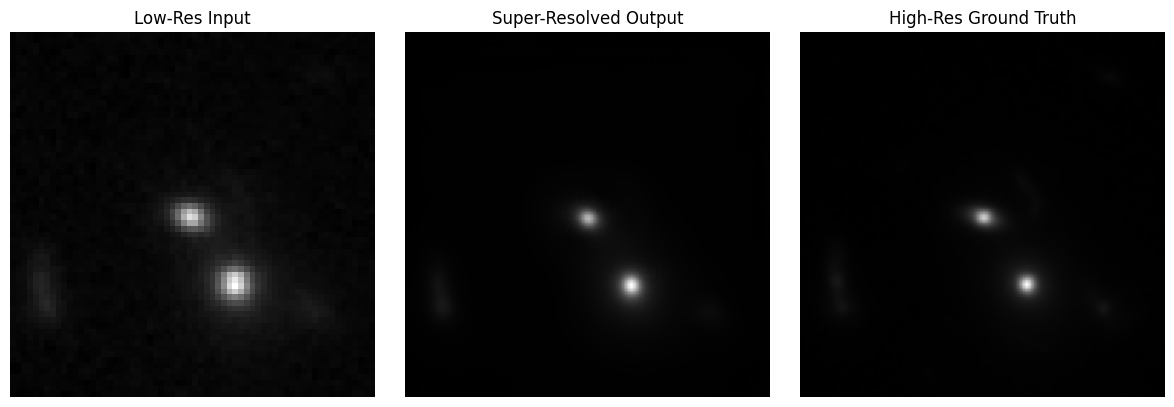

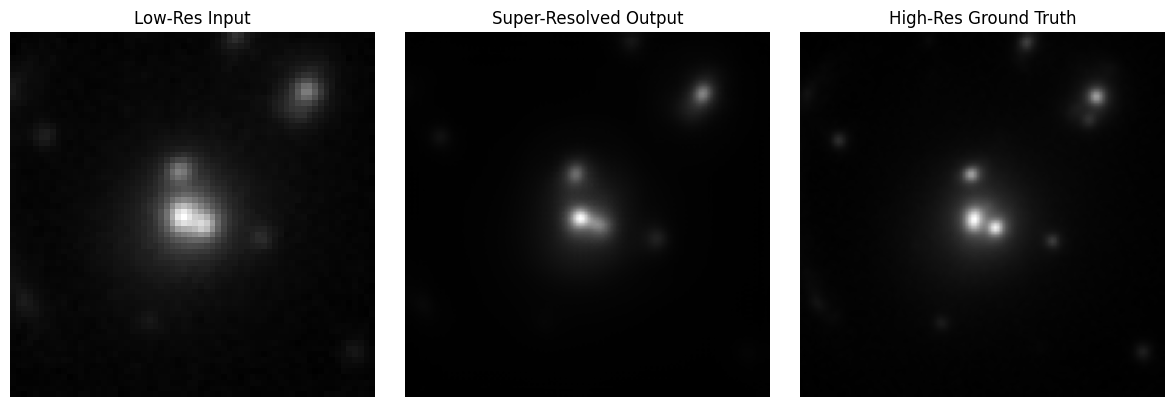

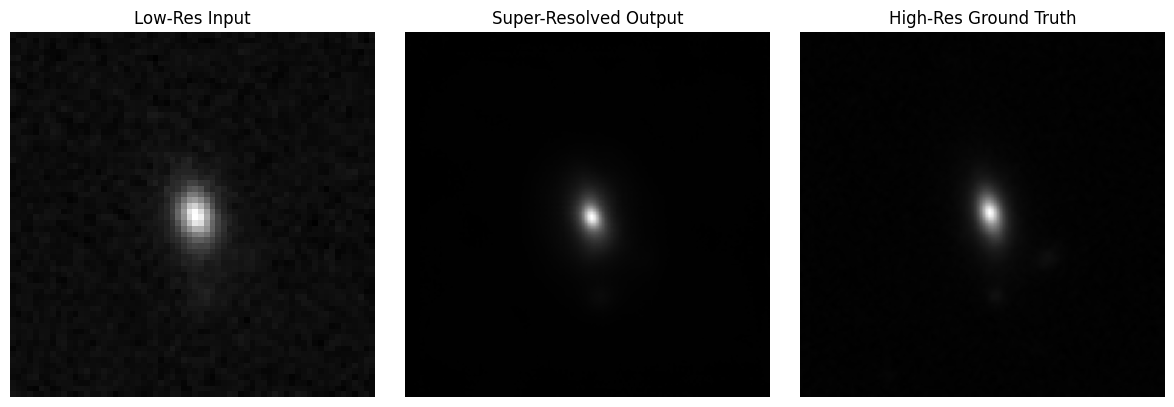

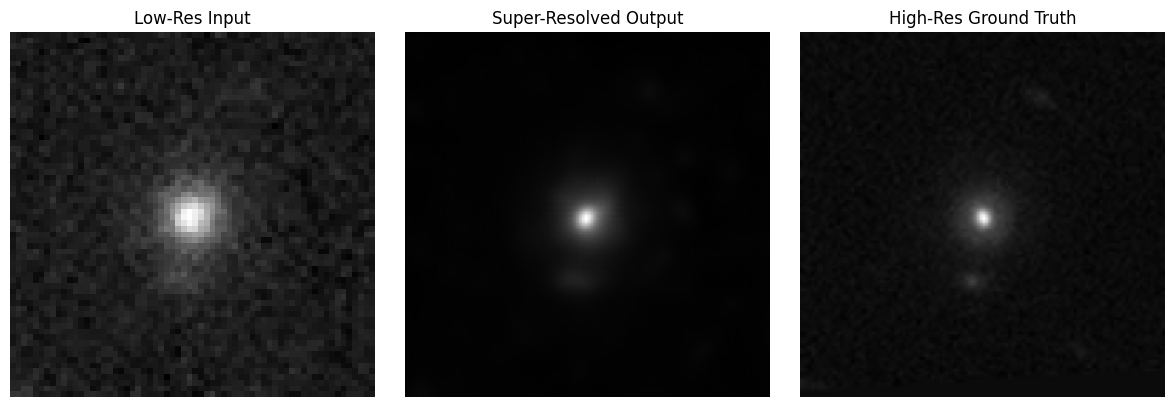

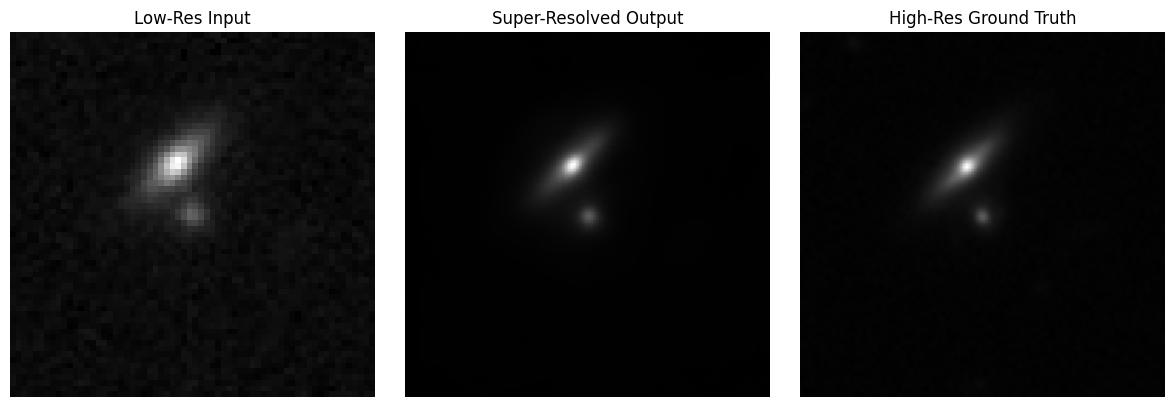

In [14]:
import matplotlib.pyplot as plt

def plot_sr_vs_hr(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        samples_plotted = 0
        for lr_imgs, hr_imgs in dataloader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)

            for i in range(lr_imgs.size(0)):
                if samples_plotted >= num_samples:
                    return
                
                lr_img = lr_imgs[i].squeeze().cpu().numpy()
                sr_img = sr_imgs[i].squeeze().cpu().numpy()
                hr_img = hr_imgs[i].squeeze().cpu().numpy()

                # Plotting
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(lr_img, cmap='gray')
                axs[0].set_title('Low-Res Input')
                axs[1].imshow(sr_img, cmap='gray')
                axs[1].set_title('Super-Resolved Output')
                axs[2].imshow(hr_img, cmap='gray')
                axs[2].set_title('High-Res Ground Truth')

                for ax in axs:
                    ax.axis('off')

                plt.tight_layout()
                plt.show()

                samples_plotted += 1
                
plot_sr_vs_hr(model, dataloader, num_samples=5)


side-by-side comparisons of Low-Resolution (LR), Super-Resolved (SR), and High-Resolution (HR) images from evaluation set.